# Titanic Survival Predictions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The sinking of the Titanic resulted in the death of 1502 out of 2224 passengers and crew.
We need to create a model that predicts which passengers were more likely to survive using passenger data like age, gender, socio-economic class, etc.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline

__author__ = "Daniela Alvarez"
__email__ = "daniela.alvarez04@gmail.com"

In [2]:
#Last model i will use is XGBClassifier

import sys
!{sys.executable} -m pip install xgboost

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
#load the data into a Pandas dataframe

def load_file(file):
    return pd.read_csv(file)

In [4]:
print("Loading data")

train_df = load_file('data/train.csv')
test_df = load_file('data/test.csv')

Loading data


In [5]:
print("The first 5 rows of the dataframe")
train_df.head()

The first 5 rows of the dataframe


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### ---- 3 Clean the data ----

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.duplicated().sum()

0

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test_df.duplicated().sum()

0

In [10]:
train_df.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smiljanic, Mr. Mile",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Exploratory Data Analysis

(0.0, 1.05)

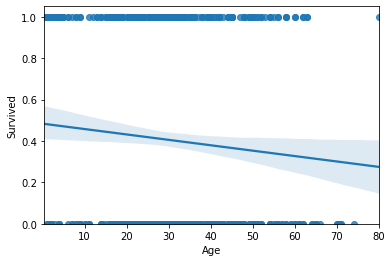

In [11]:
#View if there is a linear relation between continuous numerical variable Age & target variable Survived.
sns.regplot(x = "Age", y = "Survived", data = train_df)
plt.ylim(0,)

(0.0, 2.0996772604544036)

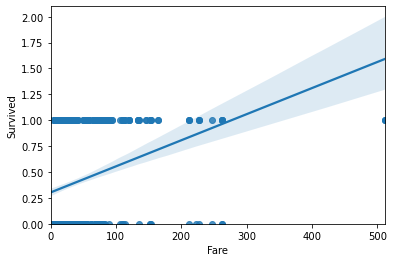

In [12]:
#View if there is a linear relation between continuous numerical variable Fare & target variable Survived.
sns.regplot(x = "Fare", y = "Survived", data = train_df)
plt.ylim(0,)

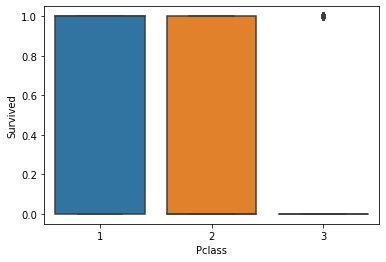

In [13]:
sns.boxplot(x= "Pclass", y = "Survived", data= train_df)

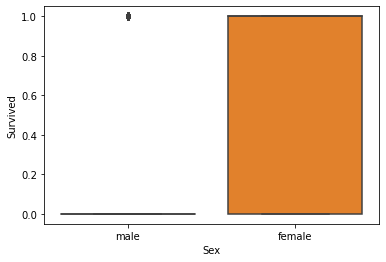

In [14]:
sns.boxplot(x= "Sex", y = "Survived", data= train_df)

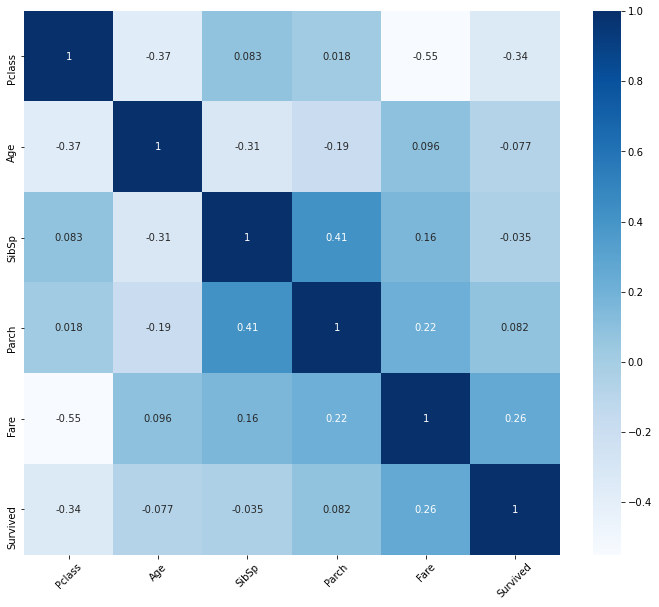

In [15]:
#Look for correlation between each feature and the target
#Look for correlation between features
#PassengerId is discarded for having unique values.

fig = plt.figure(figsize=(12,10))
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
sns.heatmap(train_df[features + ['Survived']].corr(), cmap = 'Blues', annot=True)
plt.xticks(rotation = 45)
plt.savefig('images/heatmap.png')
plt.show()


In [16]:
merge_df = train_df.append(test_df)
testcount = len(test_df)
count= len(merge_df) - testcount

In [17]:
#Delete irrelevant variables like name and ticket number. Delete Cabin because it has a 77% of missing values.
#Use passenger_id as index
#Return Survived feature to a int64 type

merge_df = merge_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis= 1)

In [18]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 92.0+ KB


In [19]:
def replace_with_avg(df, col):
    average = df[col].mean(axis=0)
    print("The average is:" , average)
    df[col].replace(np.nan, average , inplace = True)
    print("Replacing missing values with average:", average)
    

In [20]:
def replace_with_frequent(df,col):
    frequent = df[col].value_counts().idxmax()
    print("The most frequent value is:", frequent)
    df[col].replace(np.nan, frequent , inplace = True)
    print("Replacing missing values with the most frequent value:", frequent)

In [21]:
#As there are 2 values missing in "Embarked" feature, I will use the most frequent value in that feature.
replace_with_frequent(merge_df, "Embarked")

The most frequent value is: S
Replacing missing values with the most frequent value: S


In [22]:
#As there are values missing in "Age" and "Fare" feature, I will impute the average value in that feature.
replace_with_avg(merge_df, "Age")
replace_with_avg(merge_df, "Fare")

The average is: 29.881137667304014
Replacing missing values with average: 29.881137667304014
The average is: 33.29547928134557
Replacing missing values with average: 33.29547928134557


In [23]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 92.0+ KB


In [24]:
categories_df = merge_df.copy()
categories_df = merge_df.select_dtypes(include=['object'])
encoded_df = categories_df.copy()

In [25]:
encoded_df = pd.get_dummies(encoded_df)
merge_df = merge_df.drop(["Sex", "Embarked"], axis = 1)

In [26]:
final_df = pd.concat([merge_df, encoded_df], axis = 1)
train = final_df[:count]
test = final_df[count:]
train_target = train["Survived"]
train_features = train.drop(["Survived"], axis = 1)
test = test.drop(["Survived"], axis = 1)

## Training Models

In [27]:
# Knearest neighbor model, but first scaling features.

clf = KNeighborsClassifier(n_neighbors = 5)
scaler = StandardScaler()

In [28]:
pipeline = Pipeline([("transformer", scaler), ("estimator", clf)])

In [29]:
#Divide the train set in 5 folds to cross validate.
skf = StratifiedKFold(n_splits=5)

In [30]:
#Generate 5 scores as it tests 5 different times
scores = cross_val_score(pipeline, train_features, train_target, cv = skf)
print("Accuracy of the algorithm for each fold:", scores)

Accuracy of the algorithm for each fold: [0.7877095  0.78089888 0.8258427  0.80898876 0.8258427 ]


In [31]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()

In [32]:
skf_rf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [33]:
scores_rf = cross_val_score(clf_rf, train_features, train_target, cv = skf_rf)
print("Accuracy of the algorithm for each subset:", scores_rf)

Accuracy of the algorithm for each subset: [0.83798883 0.79775281 0.79775281 0.8258427  0.8258427 ]


### Now, we train the complete dataset with Random Forest Classifier

In [34]:
clf_rf.fit(train_features, train_target)

RandomForestClassifier()

### Let´s see which were the most important features

In [35]:
print(clf_rf.feature_importances_)

[0.08023645 0.25641624 0.0488406  0.03966405 0.25465177 0.14930754
 0.13488856 0.01284114 0.00834661 0.01480704]


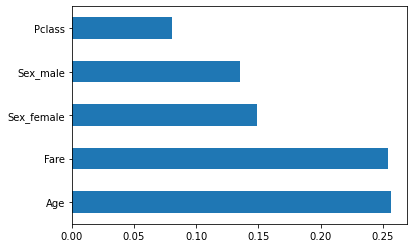

In [41]:
feat_importances = pd.Series(clf_rf.feature_importances_, index=train_features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig('images/feature_importances.png')
plt.show()

### Let's save the model, predictions and feature importances.

In [37]:
#Make predictions on test dataset and save them to csv.

predictions = clf_rf.predict(test)

np.savetxt('predictions.csv', predictions, delimiter=',')

In [38]:
#Save feature importances to csv.
feat_importances.to_csv('feature_importances.csv') 

In [39]:
#Save the model to disk.

import pickle

filename = "final_model.sav"

pickle.dump(clf_rf, open(filename, 'wb'))

### Some time in future to load model from disk

In [40]:
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)